# Building the NN using Transfer Learning

In this notebook, we put together all pieces, including one model using Transfer Learning and adjusting some parameters. We also use other measures to assess the performance of our model.

# Mounting google drive

In order to make it easy to read data from Google Drive, it can be mounted as a "local" unity. This encapsulates the connection to Google API and reduces the amount of coding that would be needed when interacting with Google API

In [1]:
# First check if running on Google Colab
try:
    from google.colab import drive

    # Install required packages
    ! pip install pandarallel
    ! pip install opencv-python

    # Mount Drive
    drive.mount("/content/gdrive", force_remount=True)

    IN_COLAB = True
    file_placement = "/content/gdrive/MyDrive/08 CS670 Artificial Intelligence/Term Project/data"
except:
    IN_COLAB = False

    # Install required packages
    ! pip install opencv-python

    import os
    file_placement = os.path.join(os.getcwd(), "..", "data")
print("running in colab?", IN_COLAB, "\ndata files:", file_placement)

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 1.2 MB/s eta 0:00:00
  Created wheel for pandarallel: filename=pandarallel-1.6.5-py3-none-any.whl size=16672 sha256=fea2f626f80de495db4ad59abe78d04b801f5c7b6ac5176b8aa98757d7640074
  Stored in directory: /root/.cache/pip/wheels/50/4f/1e/34e057bb868842209f1623f195b74fd7eda229308a7352d47f
Successfully built pandarallel
Mounted at /content/gdrive
running in colab? True 
data files: /content/gdrive/MyDrive/08 CS670 Artificial Intelligence/Term Project/data


In [2]:
import os
import matplotlib.pyplot as plt
import torch
from torch import nn
import torchvision
from torchvision import datasets, transforms
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns
import time

# Loading dataset

Again we load the pre-processed images, rezing it using PyTorch and then perform the same augmentation we have been performing so far

In [3]:
if IN_COLAB:
    base_folder = os.path.join(file_placement, "..", "..", "Publishing")
else:
    base_folder = os.path.join(file_placement, "..")
data_folder = os.path.join(base_folder, "transformed_images")
transform = transforms.Compose(
    [
      transforms.Resize(255),
      transforms.ToTensor()
    ]
)

dataset = datasets.ImageFolder(data_folder, transform=transform)

In [4]:
transform =  transforms.Compose(
    [
        transforms.Resize(255),
        transforms.RandomRotation(90),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.ToTensor()
    ]
)
dataset_augmented = datasets.ImageFolder(data_folder, transform=transform)

In [5]:
final_dataset = torch.utils.data.ConcatDataset([dataset, dataset_augmented])
train_dataset, test_dataset = torch.utils.data.random_split(
    final_dataset, [0.75, 0.25],
    generator = torch.Generator().manual_seed(42))

Let's check how many images we will have on our dataset

In [6]:
print(
    "Train dataset size:", len(train_dataset),
    "\nTest dataset size:", len(test_dataset),
    "\nTotal of images:", (len(train_dataset) + len(test_dataset))
)

Train dataset size: 9720 
Test dataset size: 3240 
Total of images: 12960


As stated in our hypothesis, we could generate a good amount of images (> 10,000) to train and test our model (while the +700 are still reserved for later validation).

# Defining the batch size

We have attempted with 3 different sizes of batch: 64, 128 and 256.

Batches of 256 were exceding the capacity of GPUs (when using Transfer Learning), even in Google Colab Pro (we had to buy some processing units in order to have enough resources to train the model). On the other hand, batches of 64 were taking too long to run. 128 items was the batch size that yielded the best tradeoff between processing time X performance withouth exceeding Google Colab Pro resources.

In [7]:
batch_size = 128
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True, drop_last=True)


# Transfer Learning using ResNet18

We now build another architecture using transfer learning from ResNet18 and SoftMax as activation layer. We started with the simples version of ResNet and would be exploring other versions, as well other architectures. However, we could get an outstanding performance (using learning rate of 0.01 and 10 epochs) with ResNet.

With ResNet18 we also tried using Adam as optmizer and started with learning rate of 0.001 without getting a good accuracy. When we used SGD along with a learning rate of 0.01 we got the outstanding performance (see below)

In [8]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = torchvision.models.resnet18(pretrained=True)
model = model.cuda() if torch.cuda.is_available() else model
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
num_ftrs = model.fc.in_features
model.fc =nn.Linear(num_ftrs, 2)
model.fc = model.fc.cuda() if torch.cuda.is_available() else model.fc

print("Training will run on:", device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 157MB/s]


Training will run on: cuda


# Creating train step

We again define a function to perform our training step (epoch)

In [9]:
def make_train_step(model, loss_fn, optimizer):
    # Builds function that performs a step in the train loop
    def train_step(x, y):
        # Sets model to TRAIN mode
        model.train()
        # Makes predictions
        yhat = model(x)
        # Computes loss
        loss = loss_fn(yhat, y)
        # Computes gradients
        loss.backward()
        # Updates parameters and zeroes gradients
        optimizer.step()
        optimizer.zero_grad()
        # Returns the loss
        return loss.item()

    # Returns the function that will be called inside the train loop
    return train_step

# Creates the train_step function for our model, loss function and optimizer
train_step = make_train_step(model, loss_fn, optimizer)
losses = []
n_epochs = 10

# Training model

And perform the training of our model

In [10]:
n_epochs = 10
losses = []
test_losses = []
train_step = make_train_step(model, loss_fn, optimizer)
log_training = []
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

for epoch in range(n_epochs):
    start = torch.cuda.Event(enable_timing=True)
    end = torch.cuda.Event(enable_timing=True)
    log_row = {
        "epoch": epoch + 1,
        "start time": time.time(),
        "start GPU time": start}
    print(epoch + 1, "/", n_epochs)
    for x_batch, y_batch in train_dataloader:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)

        loss = train_step(x_batch, y_batch)
        losses.append(loss)

    print("Train loss:", np.mean(losses))
    log_row["train loss"] = np.mean(losses)

    # torch no_grad makes sure that the nested-below computations happen without gradients,
    # since these are not needed for evaluation
    with torch.no_grad():
        for x_test, y_test in test_dataloader:
            x_test = x_test.to(device)
            y_test = y_test.to(device)

            model.eval()

            yhat = model(x_test)
            test_loss = loss_fn(yhat, y_test)
            test_losses.append(test_loss.item())
        print("Test loss:", np.mean(test_losses))
        log_row["test loss"] = np.mean(test_losses)
    log_row["end time"] = time.time()
    log_row["end GPU time"] = end.record()
    torch.cuda.synchronize()
    log_training.append(log_row)

cuda
1 / 10
Train loss: 0.044545939730790754
Test loss: 0.0013598902663215994
2 / 10
Train loss: 0.02311148787344185
Test loss: 0.0011394543841015548
3 / 10
Train loss: 0.01576084984324148
Test loss: 0.0009633533051237464
4 / 10
Train loss: 0.012089137913038334
Test loss: 0.0008484781740116887
5 / 10
Train loss: 0.009839699824495863
Test loss: 0.0007590660988353192
6 / 10
Train loss: 0.008297171563479222
Test loss: 0.0006860093199065886
7 / 10
Train loss: 0.00719151181252008
Test loss: 0.0006358146378936778
8 / 10
Train loss: 0.006340289482589773
Test loss: 0.0005925982244662009
9 / 10
Train loss: 0.0056819302903238205
Test loss: 0.000553297722298238
10 / 10
Train loss: 0.005155409742321353
Test loss: 0.0005201795301400125


In [11]:
training_statistics = pd.DataFrame(log_training)

<function matplotlib.pyplot.show(close=None, block=None)>

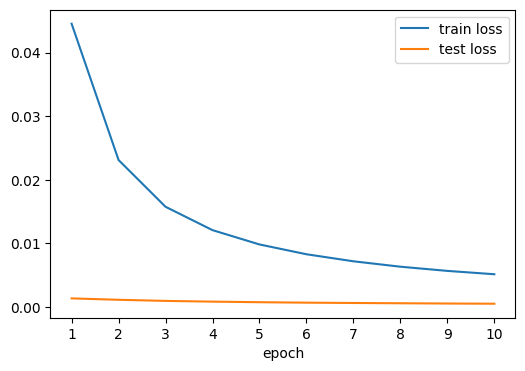

In [12]:
plt.rcParams["figure.figsize"] = (6, 4)
plt.plot(training_statistics["train loss"], label="train loss")
plt.plot(training_statistics["test loss"], label="test loss")
plt.legend()
plt.xlabel("epoch")
plt.xticks(training_statistics.index, training_statistics["epoch"])
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

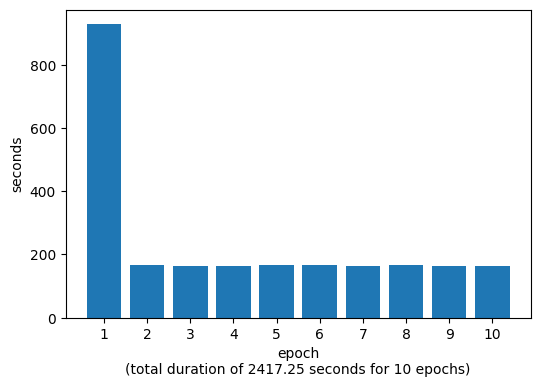

In [13]:
training_statistics["duration"] = training_statistics["end time"] - training_statistics["start time"]
plt.rcParams["figure.figsize"] = (6, 4)
plt.bar(training_statistics["epoch"], training_statistics["duration"])
plt.ylabel("seconds")
total_duration = training_statistics["duration"].sum()
plt.xlabel(f"epoch\n(total duration of {str(round(total_duration, 2))} seconds for 10 epochs)")
plt.xticks(training_statistics["epoch"])
plt.show
# training_statistics

# Checking Performance

Here we define a function to check the performance. This function will receive the trained model and the test set and will output:

* The confusion matrix
* Accuracy
* Precision
* Recall
* F1-Score

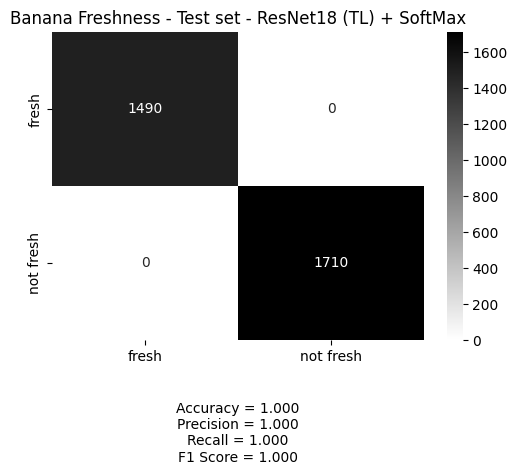

In [14]:
def check_performance(model, test_dataloader, type_of_set):
  all_true = []
  all_preds = []
  model.eval()
  for X, y in test_dataloader:
    X = X.to(device)
    y = y.to(device)

    trues = y
    preds = model(X).argmax(axis=1)
    all_true.extend(list(trues.cpu().numpy()))
    all_preds.extend(list(preds.cpu().numpy()))

  performance = pd.DataFrame({"true": all_true, "predicted": all_preds})
  cm = confusion_matrix(performance["true"], performance["predicted"])
  sns.heatmap(cm, annot=True, fmt=".0f", cmap="binary",
              xticklabels = ["fresh", "not fresh"], yticklabels = ["fresh", "not fresh"])
  #Metrics for Binary Confusion Matrices
  accuracy  = np.trace(cm) / float(np.sum(cm))
  precision = cm[1,1] / sum(cm[:,1])
  recall    = cm[1,1] / sum(cm[1,:])
  f1_score  = 2*precision*recall / (precision + recall)
  stats_text = "\n\nAccuracy = {:0.3f}\nPrecision = {:0.3f}\nRecall = {:0.3f}\nF1 Score = {:0.3f}".format(
      accuracy, precision, recall, f1_score)

  plt.title(f"Banana Freshness - {type_of_set}")
  plt.xlabel(stats_text)
  # return performance

check_performance(model, test_dataloader, "Test set - ResNet18 (TL) + SoftMax")
# test_dataloader

# Checking some images

Let's check some images and their true and predicted label, just to make sure everything is working as expected.

In [15]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    plt.imshow(inp)

torch.Size([128, 3, 255, 255])


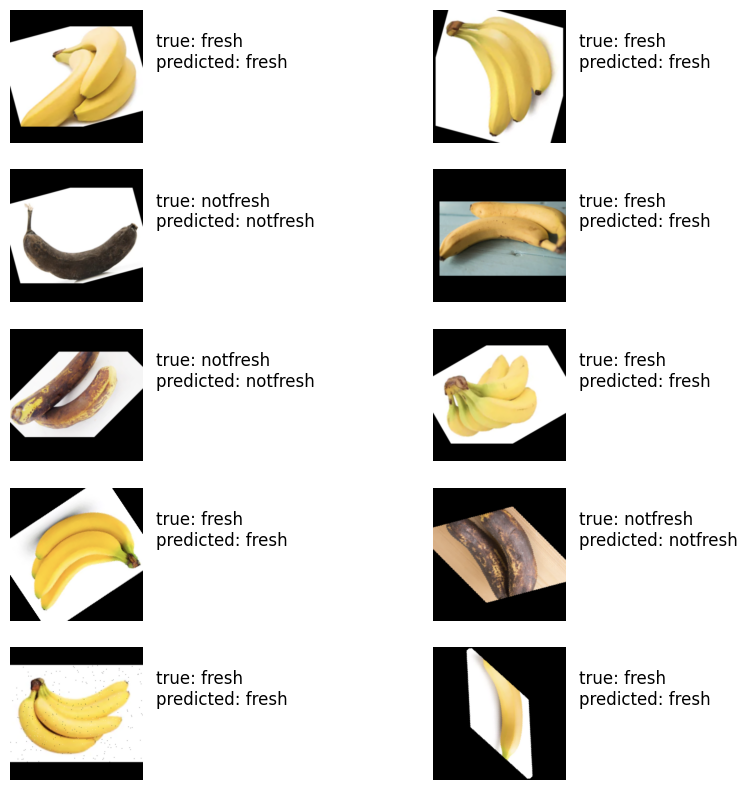

In [16]:
def visualize_model(model, test_batch, class_names, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure(figsize=(10, 10))

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(test_batch):
            print(inputs.shape)
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f"true: {class_names[labels[j]]}\npredicted: {class_names[preds[j]]}", x=1.1, y=.5, loc="left")
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

class_names = dataset.classes
visualize_model(model, test_dataloader, class_names, 10)

# Saving the model

We save the model to use it later with our validation dataset

In [17]:
if IN_COLAB:
    base_folder = os.path.join(file_placement, "..", "..", "Publishing")
else:
    base_folder = os.path.join(file_placement, "..")
model_folder = os.path.join(base_folder, "saved_model")
torch.save(model, os.path.join(model_folder, "fresh_banana_classification.pth"))